<a href="https://colab.research.google.com/github/wintershine987/sea-level-rise-fisheries-AI/blob/main/RF%20test%20result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Global_production_quantity.csv to Global_production_quantity.csv



[TRAIN] negatives in predictions: 0
[TRAIN] opposite-sign pairs: 1434
[TRAIN] y < 1.0 count: 2401

[TEST] negatives in predictions: 0
[TEST] opposite-sign pairs: 497
[TEST] y < 1.0 count: 753

Train metrics: {'COR': 0.9824, 'RMSE': 49963.1331, 'MAE': 2666.7038, 'R2': 0.9582, 'MinMaxAcc_raw': 0.7301, 'MinMaxAcc_safe': 0.8521, 'SD': 49919.4775}
Test  metrics: {'COR': 0.9859, 'RMSE': 38113.8516, 'MAE': 4581.5263, 'R2': 0.9431, 'MinMaxAcc_raw': 0.6098, 'MinMaxAcc_safe': 0.7045, 'SD': 38029.4536}


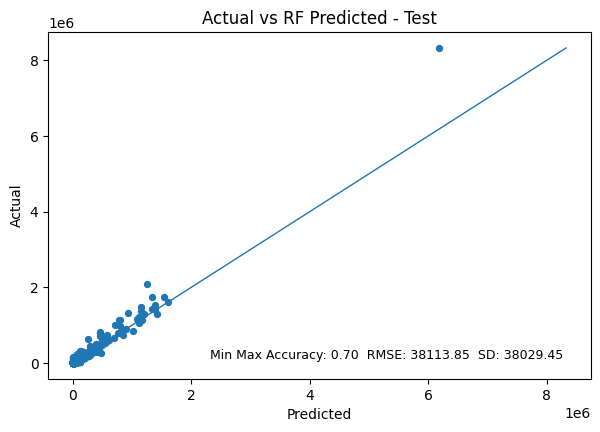

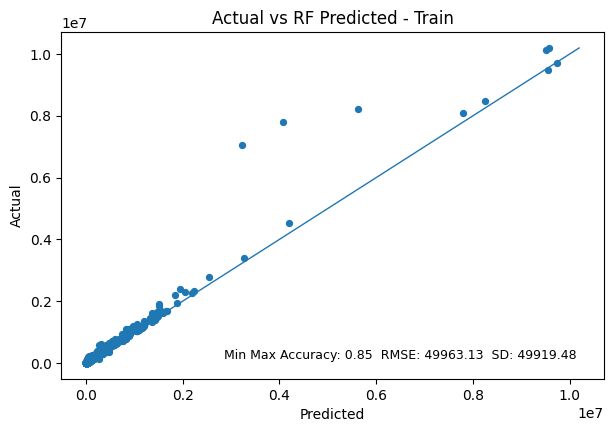

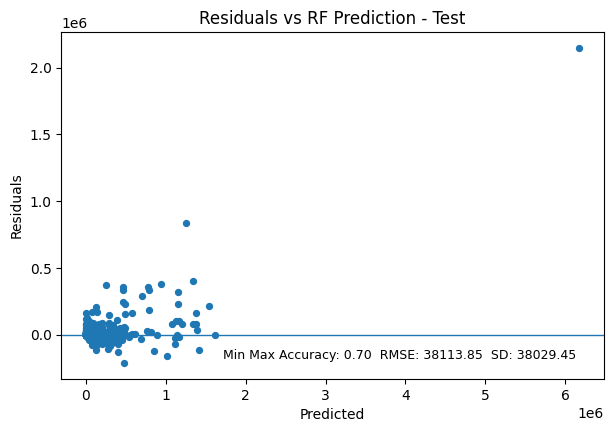

In [7]:

# Random Forest + Inline plots + Safe Min–Max Accuracy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor


student_id = 308767
target = "VALUE"
csv_path = "Global_production_quantity.csv"

SEA_FILTER = True
USE_LOG1P  = True
Y_FLOOR    = 1e-3

# Metrics

def correlation_pearson(y_true, y_pred):
    return float(np.corrcoef(y_true, y_pred)[0, 1])

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred):
    return float(mean_absolute_error(y_true, y_pred))

def r2(y_true, y_pred):
    return float(r2_score(y_true, y_pred))

def minmax_accuracy_raw(y_true, y_pred):
    """
    Original definition: mean(min(y, yhat)/max(y, yhat)).
    Can go negative with opposite signs; extremely small denominators can explode magnitude.
    """
    y = np.asarray(y_true, dtype=float)
    yhat = np.asarray(y_pred, dtype=float)
    denom = np.maximum(y, yhat)
    with np.errstate(divide="ignore", invalid="ignore"):
        r = np.divide(np.minimum(y, yhat), denom, out=np.zeros_like(y), where=denom != 0)
    return float(np.mean(r))

def minmax_acc_safe(y_true, y_pred, eps=1e-12, y_floor=None):
    """
    Always in [0,1].
    - Uses min(|y|,|yhat|)/max(|y|,|yhat|).
    - Opposite signs are penalized as 0.
    - Optionally exclude tiny y via y_floor.
    """
    y = np.asarray(y_true, float)
    yhat = np.asarray(y_pred, float)

    if y_floor is not None:
        mask = y >= y_floor
        if mask.any():
            y, yhat = y[mask], yhat[mask]
        else:
            return 0.0  # no samples after filtering

    denom = np.maximum(np.abs(y), np.abs(yhat))
    numer = np.minimum(np.abs(y), np.abs(yhat))
    with np.errstate(divide="ignore", invalid="ignore"):
        r = np.divide(numer, denom + eps, out=np.zeros_like(y), where=denom > 0)

    # Opposite sign -> 0; Both ~0 -> 1
    r[np.sign(y) != np.sign(yhat)] = 0.0
    both_zero = (np.abs(y) <= eps) & (np.abs(yhat) <= eps)
    r[both_zero] = 1.0
    return float(np.mean(r)) if r.size else 0.0

def residual_sd(y_true, y_pred):
    res = np.asarray(y_true, float) - np.asarray(y_pred, float)
    return float(np.std(res, ddof=1))

def pack_metrics(y_true, y_pred, y_floor=None):
    # For MinMaxAcc we clip preds to non-negative JUST for that metric
    y_pred_nn = np.maximum(y_pred, 0.0)
    return {
        "COR": correlation_pearson(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAE": mae(y_true, y_pred),
        "R2": r2(y_true, y_pred),
        "MinMaxAcc_raw":  minmax_accuracy_raw(y_true, y_pred),
        "MinMaxAcc_safe": minmax_acc_safe(y_true, y_pred_nn, y_floor=y_floor),
        "SD": residual_sd(y_true, y_pred), }

def annotate(ax, m):
    ax.text(
        0.95, 0.05,
        f"Min Max Accuracy: {m['MinMaxAcc_safe']:.2f}  RMSE: {m['RMSE']:.2f}  SD: {m['SD']:.2f}",
        transform=ax.transAxes, fontsize=9, ha="right", va="bottom" )

# Data: load, filter, encode

df = pd.read_csv(csv_path)
df = df.dropna(subset=[target]).copy()

if SEA_FILTER and set(["COUNTRY.UN_CODE", "PERIOD"]).issubset(df.columns):
    sea_codes = [96, 104, 116, 360, 458, 608, 626, 702, 764, 704]
    df = df[df["COUNTRY.UN_CODE"].isin(sea_codes) & df["PERIOD"].between(2005, 2023)]

X = df.drop(columns=[target])
y = df[target].astype(float)

# Label-encode object/categorical columns
for col in X.columns:
    if X[col].dtype == object:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))


# 60/20/20 split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.60, random_state=student_id)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, train_size=0.50, random_state=student_id)

# Train on Train+Valid
X_full = pd.concat([X_train, X_valid], axis=0)
y_full = pd.concat([y_train, y_valid], axis=0)

# Model: RandomForestRegressor (with optional log1p target transform)

rf_base = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    random_state=student_id,
    n_jobs=-1,)


if USE_LOG1P:
    model = TransformedTargetRegressor(
        regressor=rf_base, func=np.log1p, inverse_func=np.expm1 )
else:
    model = rf_base

model.fit(X_full, y_full)

# Predictions

yhat_train = model.predict(X_train)
yhat_test  = model.predict(X_test)


# Quick diagnostics

def quick_diagnose(name, y, yhat, small=1.0):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    print(f"\n[{name}] negatives in predictions:", int((yhat < 0).sum()))
    print(f"[{name}] opposite-sign pairs:", int(np.sum(np.sign(y) != np.sign(yhat))))
    print(f"[{name}] y < {small} count:", int((y < small).sum()))

quick_diagnose("TRAIN", y_train, yhat_train, small=1.0)
quick_diagnose("TEST",  y_test,  yhat_test,  small=1.0)

# Metrics

m_test  = pack_metrics(y_test,  yhat_test,  y_floor=Y_FLOOR)
m_train = pack_metrics(y_train, yhat_train, y_floor=Y_FLOOR)

print("\nTrain metrics:",
      {k: (round(v, 4) if isinstance(v, float) else v) for k, v in m_train.items()})
print("Test  metrics:",
      {k: (round(v, 4) if isinstance(v, float) else v) for k, v in m_test.items()})

# Plots
# A: Actual vs Predicted (Test)
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.scatter(yhat_test, y_test, s=18)
mn = min(np.min(yhat_test), np.min(y_test))
mx = max(np.max(yhat_test), np.max(y_test))
ax.plot([mn, mx], [mn, mx], linewidth=1)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Actual vs RF Predicted - Test")
annotate(ax, m_test)
plt.show()

# B: Actual vs Predicted (Train)
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.scatter(yhat_train, y_train, s=18)
mn = min(np.min(yhat_train), np.min(y_train))
mx = max(np.max(yhat_train), np.max(y_train))
ax.plot([mn, mx], [mn, mx], linewidth=1)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Actual vs RF Predicted - Train")
annotate(ax, m_train)
plt.show()

# C: Residuals vs Predicted (Test)
resid = y_test - yhat_test
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.scatter(yhat_test, resid, s=18)
ax.axhline(0.0, linewidth=1)
ax.set_xlabel("Predicted")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs RF Prediction - Test")
annotate(ax, m_test)
plt.show()
